In [ ]:
import math, os, sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from mylogger import NewLogger

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [2]:
logger = None
logger = NewLogger(test=True, result_path='./log/', model_name=None)

In [3]:
UAPH_PATH = './data/ctu/uaph.csv'
DATA_PATH = './data/ctu/ctu_csv/'
BATCH_SIZE = 10

In [4]:
# CTG Dataset

class CTGDataset(data.Dataset):
    def __init__(self, fhr_path_list, toco_path_list):
        self.fhr_path_list = fhr_path_list
        self.toco_path_list = toco_path_list

    def __len__(self):
        return len(self.fhr_path_list)

    def __getitem__(self, index):
        
        fhr_data = self.path2tensor(self.fhr_path_list[index])
        toco_data = self.path2tensor(self.toco_path_list[index])  
        
        return fhr_data, toco_data
    
    @staticmethod
    def path2tensor(path):
        np_data = pd.read_csv(path, header=None).values.reshape([-1])
        np_data = np_data[-14400:]
        nn_data = torch.from_numpy(np_data).to(torch.float).reshape(1, -1)
        return nn_data

In [5]:
uaph = pd.read_csv(UAPH_PATH, header=None).values.reshape([-1])
DATA_SIZE = len(uaph)

fhr_path_list = []
toco_path_list = []
        
for i in range(1, DATA_SIZE + 1):
    fhr_path_list += [DATA_PATH + '{}_fhr.csv'.format(str(i))]
    toco_path_list += [DATA_PATH + '{}_toco.csv'.format(str(i))]

dataset = CTGDataset(fhr_path_list, toco_path_list)
dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
index_list = []
for i in range(DATA_SIZE):
    if uaph[i] < 7.15:
        index_list += [i]
        
p = 0

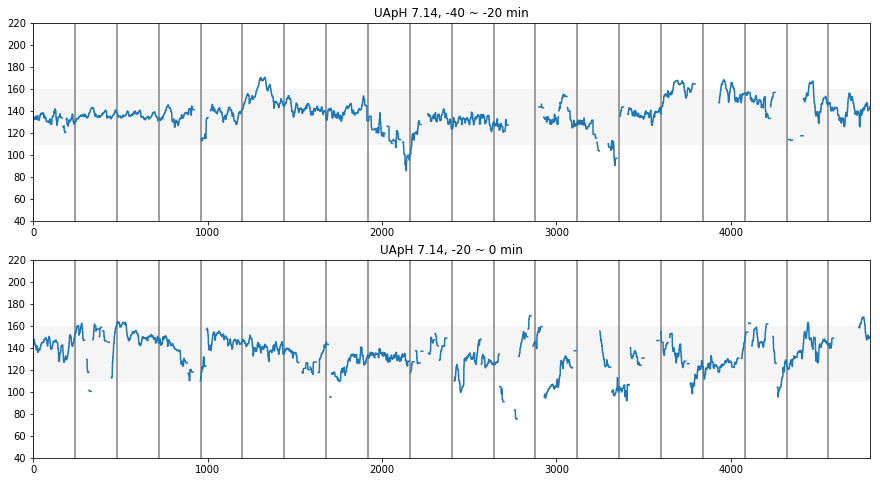

In [34]:
p += 1
index = index_list[p]

d = 20

mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

fhr = dataset[index][0].reshape(-1)
fhr = np.where(fhr == 0.0, np.nan, fhr)

fig = plt.figure(figsize=(15, 8))

for i in range(2):
    ax = plt.subplot(2,1,i+1)

    rec = pat.Rectangle(xy=(0, 110), width=d * 240, height=50,
                        color="whitesmoke", alpha=1)
    ax.add_patch(rec)
    
    for j in range(d):
        plt.axvline(x=j*240, color="gray")
    
    start = (i - 2) * d
    end = (i - 1) * d
    
    ax.plot(fhr[start*240: end*240-1])

    ax.set_title('UApH {:.2f}, {} ~ {} min'.format(uaph[index], start, end))
    plt.ylim([40,220])
